In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [3]:
customers = pd.read_csv('D:\\Project\\DataMining\\ecommerce-customer-analytics\\data\\raw\\olist_customers_dataset.csv')
orders = pd.read_csv('D:\\Project\\DataMining\\ecommerce-customer-analytics\\data\\raw\\olist_orders_dataset.csv')
order_items = pd.read_csv('D:\\Project\\DataMining\\ecommerce-customer-analytics\\data\\raw\\olist_order_items_dataset.csv')
products = pd.read_csv('D:\\Project\\DataMining\\ecommerce-customer-analytics\\data\\raw\\olist_products_dataset.csv')
payments = pd.read_csv('D:\\Project\\DataMining\\ecommerce-customer-analytics\\data\\raw\\olist_order_payments_dataset.csv')

print("Data loaded successfully!")
print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Order Items: {order_items.shape}")
print(f"Products: {products.shape}")
print(f"Payments: {payments.shape}")

Data loaded successfully!
Customers: (99441, 5)
Orders: (99441, 8)
Order Items: (112650, 7)
Products: (32951, 9)
Payments: (103886, 5)


In [4]:
print("=== CUSTOMERS ===")
print(customers.head())
print(f"Shape: {customers.shape}")
print(f"Columns: {customers.columns.tolist()}")
print(f"Missing values: {customers.isnull().sum().sum()}")

=== CUSTOMERS ===
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
Shape: (99441, 5)
Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Missing

In [5]:
revenue_data = order_items.groupby('order_id')[['price', 'freight_value']].sum()
revenue_data['total_revenue'] = revenue_data['price'] + revenue_data['freight_value']

print(f"Total Revenue: ${revenue_data['total_revenue'].sum():,.2f}")
print(f"Average Order Value: ${revenue_data['total_revenue'].mean():.2f}")
print(f"Total Orders: {len(revenue_data):,}")
print(f"Total Customers: {customers['customer_unique_id'].nunique():,}")

Total Revenue: $15,843,553.24
Average Order Value: $160.58
Total Orders: 98,666
Total Customers: 96,096


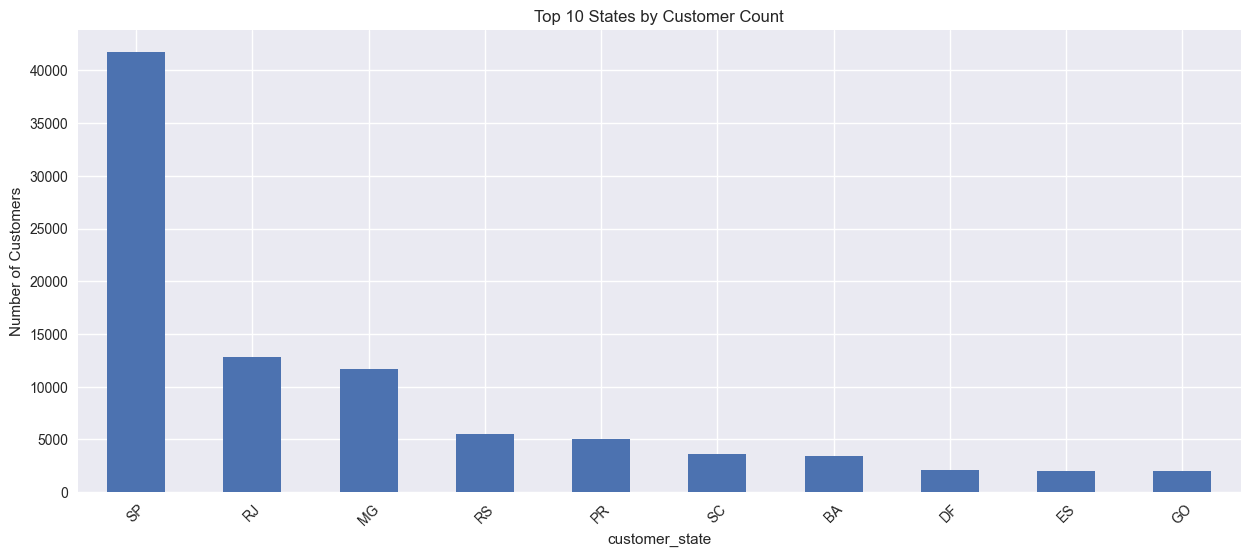

In [6]:
customer_states = customers['customer_state'].value_counts()
plt.figure(figsize=(15, 6))
customer_states.head(10).plot(kind='bar')
plt.title('Top 10 States by Customer Count')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

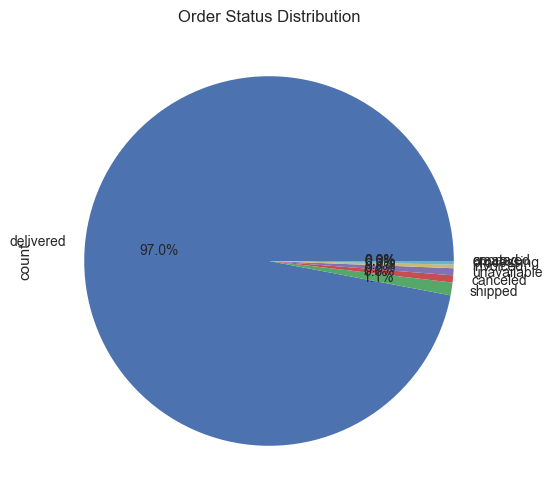

In [7]:
order_status = orders['order_status'].value_counts()
plt.figure(figsize=(10, 6))
order_status.plot(kind='pie', autopct='%1.1f%%')
plt.title('Order Status Distribution')
plt.show()

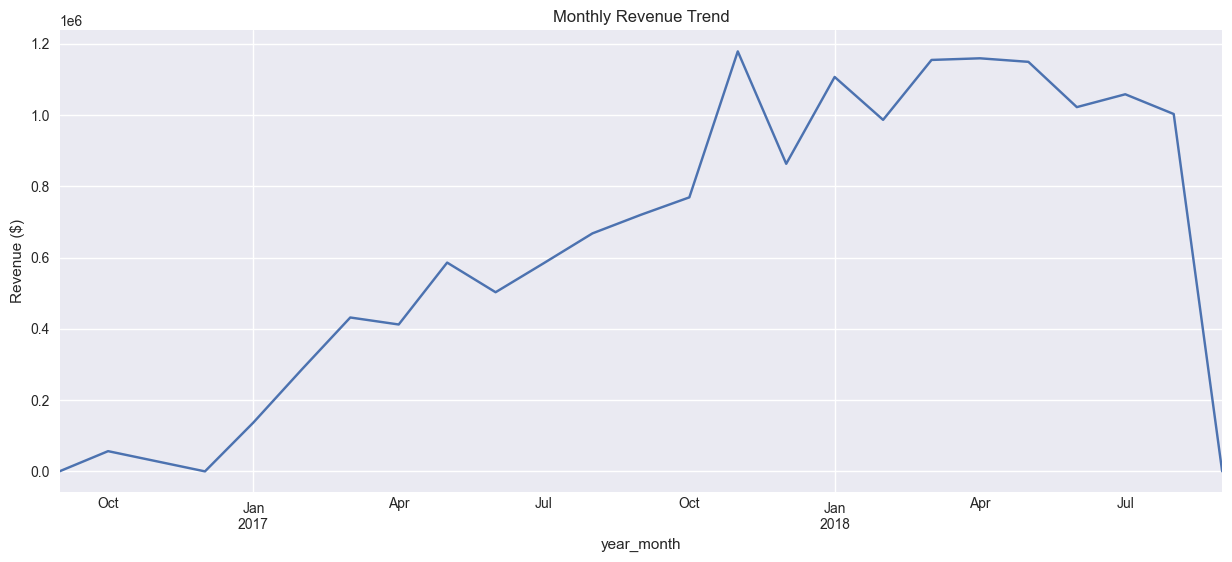

In [8]:
orders_revenue = orders.merge(revenue_data.reset_index(), on='order_id')
orders_revenue['order_purchase_timestamp'] = pd.to_datetime(orders_revenue['order_purchase_timestamp'])
orders_revenue['year_month'] = orders_revenue['order_purchase_timestamp'].dt.to_period('M')

monthly_revenue = orders_revenue.groupby('year_month')['total_revenue'].sum()


plt.figure(figsize=(15, 6))
monthly_revenue.plot()
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue ($)')
plt.show()

In [9]:
customer_master = customers.merge(
    orders[['customer_id', 'order_id', 'order_purchase_timestamp', 'order_status']], 
    on='customer_id'
).merge(
    revenue_data.reset_index()[['order_id', 'total_revenue']], 
    on='order_id'
)

# Calculate customer-level metrics
customer_summary = customer_master.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'total_revenue': ['sum', 'mean'],
    'order_purchase_timestamp': ['min', 'max']
}).round(2)

# Flatten column names
customer_summary.columns = ['total_orders', 'total_spent', 'avg_order_value', 'first_order', 'last_order']
customer_summary = customer_summary.reset_index()

print("Customer Master Dataset Created!")
print(customer_summary.head())

Customer Master Dataset Created!
                 customer_unique_id  total_orders  total_spent  \
0  0000366f3b9a7992bf8c76cfdf3221e2             1       141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f             1        27.19   
2  0000f46a3911fa3c0805444483337064             1        86.22   
3  0000f6ccb0745a6a4b88665a16c9f078             1        43.62   
4  0004aac84e0df4da2b147fca70cf8255             1       196.89   

   avg_order_value          first_order           last_order  
0           141.90  2018-05-10 10:56:27  2018-05-10 10:56:27  
1            27.19  2018-05-07 11:11:27  2018-05-07 11:11:27  
2            86.22  2017-03-10 21:05:03  2017-03-10 21:05:03  
3            43.62  2017-10-12 20:29:41  2017-10-12 20:29:41  
4           196.89  2017-11-14 19:45:42  2017-11-14 19:45:42  


#9 Customer Behavior Deep Dive

=== CUSTOMER BEHAVIOR ANALYSIS ===
Order Frequency Distribution:
1 orders: 92,507 customers (96.9%)
2 orders: 2,673 customers (2.8%)
3 orders: 192 customers (0.2%)
4 orders: 29 customers (0.0%)
5 orders: 9 customers (0.0%)
6 orders: 5 customers (0.0%)
7 orders: 3 customers (0.0%)
9 orders: 1 customers (0.0%)
16 orders: 1 customers (0.0%)


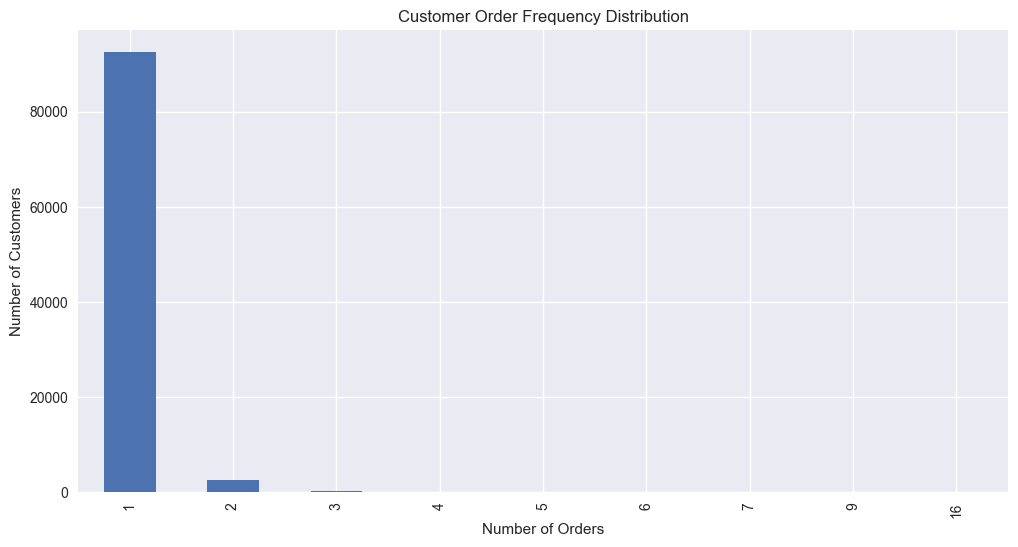

In [10]:
print("=== CUSTOMER BEHAVIOR ANALYSIS ===")

# Customer order frequency distribution
customer_orders = customer_summary['total_orders'].value_counts().sort_index()
print("Order Frequency Distribution:")
for orders, count in customer_orders.head(10).items():
    print(f"{orders} orders: {count:,} customers ({count/len(customer_summary)*100:.1f}%)")

plt.figure(figsize=(12, 6))
customer_orders.head(10).plot(kind='bar')
plt.title('Customer Order Frequency Distribution')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

10. Revenue Distribution Analysis

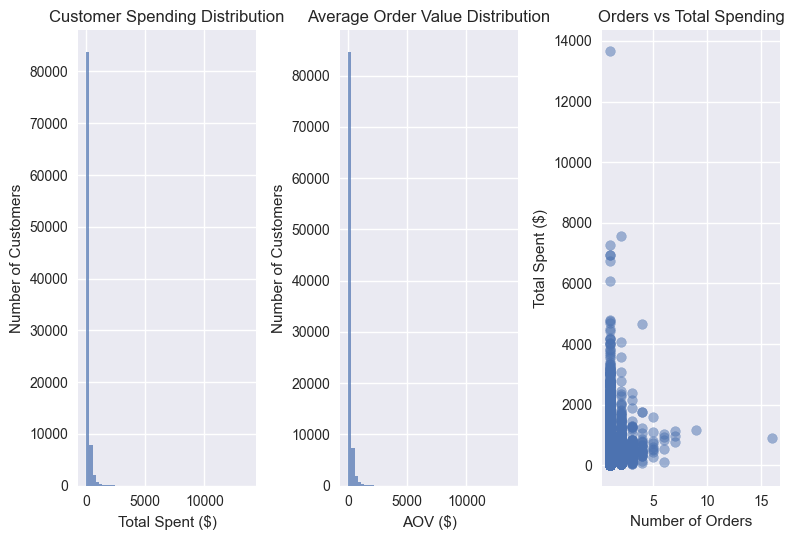

In [11]:
# Subplot 1: Customer spending distribution
plt.subplot(1, 3, 1)
plt.hist(customer_summary['total_spent'], bins=50, alpha=0.7)
plt.title('Customer Spending Distribution')
plt.xlabel('Total Spent ($)')
plt.ylabel('Number of Customers')

# Subplot 2: Average order value distribution  
plt.subplot(1, 3, 2)
plt.hist(customer_summary['avg_order_value'], bins=50, alpha=0.7)
plt.title('Average Order Value Distribution')
plt.xlabel('AOV ($)')
plt.ylabel('Number of Customers')

# Subplot 3: Spending vs Orders correlation
plt.subplot(1, 3, 3)
plt.scatter(customer_summary['total_orders'], customer_summary['total_spent'], alpha=0.5)
plt.title('Orders vs Total Spending')
plt.xlabel('Number of Orders')
plt.ylabel('Total Spent ($)')

plt.tight_layout()
plt.show()

11. Business Insights Summary

In [12]:
print("=== KEY BUSINESS INSIGHTS ===")

# Top customers analysis
top_10_customers = customer_summary.nlargest(10, 'total_spent')
print(f"Top 10 customers spent: ${top_10_customers['total_spent'].sum():,.2f}")
print(f"This is {top_10_customers['total_spent'].sum()/customer_summary['total_spent'].sum()*100:.1f}% of total revenue")

# Customer segments rough identification
one_time_buyers = len(customer_summary[customer_summary['total_orders'] == 1])
repeat_buyers = len(customer_summary[customer_summary['total_orders'] > 1])
loyal_customers = len(customer_summary[customer_summary['total_orders'] >= 5])

print(f"\nCustomer Segments (Rough):")
print(f"One-time buyers: {one_time_buyers:,} ({one_time_buyers/len(customer_summary)*100:.1f}%)")
print(f"Repeat buyers: {repeat_buyers:,} ({repeat_buyers/len(customer_summary)*100:.1f}%)")
print(f"Loyal customers (5+ orders): {loyal_customers:,} ({loyal_customers/len(customer_summary)*100:.1f}%)")

# Revenue contribution
one_time_revenue = customer_summary[customer_summary['total_orders'] == 1]['total_spent'].sum()
repeat_revenue = customer_summary[customer_summary['total_orders'] > 1]['total_spent'].sum()

print(f"\nRevenue Contribution:")
print(f"One-time buyers: ${one_time_revenue:,.2f} ({one_time_revenue/customer_summary['total_spent'].sum()*100:.1f}%)")
print(f"Repeat buyers: ${repeat_revenue:,.2f} ({repeat_revenue/customer_summary['total_spent'].sum()*100:.1f}%)")

=== KEY BUSINESS INSIGHTS ===
Top 10 customers spent: $69,425.87
This is 0.4% of total revenue

Customer Segments (Rough):
One-time buyers: 92,507 (96.9%)
Repeat buyers: 2,913 (3.1%)
Loyal customers (5+ orders): 19 (0.0%)

Revenue Contribution:
One-time buyers: $14,939,106.99 (94.3%)
Repeat buyers: $904,446.25 (5.7%)


12. Product Category Analysis

=== TOP 10 CATEGORIES BY REVENUE ===
  product_category_name_english  total_revenue  avg_price  units_sold
0                 health_beauty     1258681.34     130.16        9670
1                 watches_gifts     1205005.68     201.14        5991
2                bed_bath_table     1036988.68      93.30       11115
3                sports_leisure      988048.97     114.34        8641
4         computers_accessories      911954.32     116.51        7827
5               furniture_decor      729762.49      87.56        8334
6                    cool_stuff      635290.85     167.36        3796
7                    housewares      632248.66      90.79        6964
8                          auto      592720.11     139.96        4235
9                  garden_tools      485256.46     111.63        4347


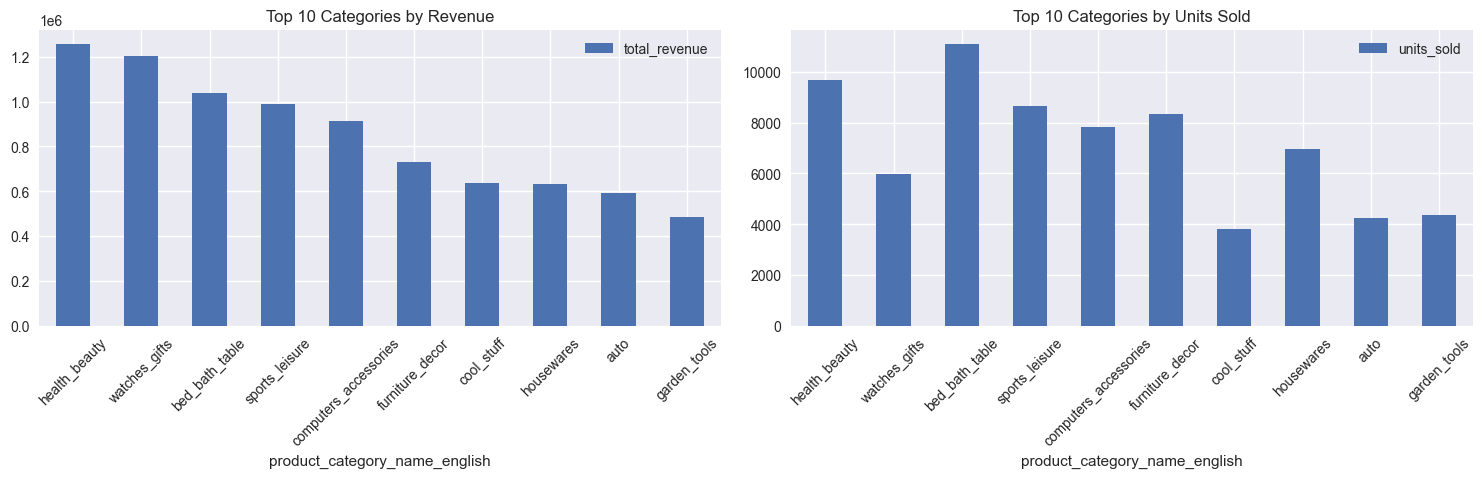

In [13]:
# Load and merge product data
category_translation = pd.read_csv('../data/raw/product_category_name_translation.csv')
products_enhanced = products.merge(category_translation, on='product_category_name', how='left')

# Category performance analysis
category_sales = order_items.merge(
    products_enhanced[['product_id', 'product_category_name_english']], 
    on='product_id'
).groupby('product_category_name_english').agg({
    'price': ['sum', 'mean', 'count']
}).round(2)

category_sales.columns = ['total_revenue', 'avg_price', 'units_sold']
category_sales = category_sales.sort_values('total_revenue', ascending=False).reset_index()

print("=== TOP 10 CATEGORIES BY REVENUE ===")
print(category_sales.head(10))

# Visualization
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
category_sales.head(10).plot(x='product_category_name_english', y='total_revenue', kind='bar', ax=plt.gca())
plt.title('Top 10 Categories by Revenue')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
category_sales.head(10).plot(x='product_category_name_english', y='units_sold', kind='bar', ax=plt.gca())
plt.title('Top 10 Categories by Units Sold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

13. RFM Data Preparation

In [14]:
from datetime import datetime

# Set analysis date (last order date + 1 day)
analysis_date = pd.to_datetime('2018-10-17')  # Based on dataset end date

# Prepare RFM calculation data
rfm_data = customer_master.copy()
rfm_data['order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'])

# Calculate RFM metrics for each customer
rfm_table = rfm_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'total_revenue': 'sum'  # Monetary
}).round(2)

rfm_table.columns = ['Recency', 'Frequency', 'Monetary']
rfm_table = rfm_table.reset_index()

print("=== RFM TABLE CREATED ===")
print(f"Shape: {rfm_table.shape}")
print(rfm_table.describe())
print("\nSample data:")
print(rfm_table.head(10))

=== RFM TABLE CREATED ===
Shape: (95420, 4)
            Recency     Frequency      Monetary
count  95420.000000  95420.000000  95420.000000
mean     286.501467      1.034018    166.040172
std      153.160846      0.211234    228.320333
min       43.000000      1.000000      9.590000
25%      162.000000      1.000000     63.100000
50%      267.000000      1.000000    107.940000
75%      396.000000      1.000000    183.220000
max      772.000000     16.000000  13664.080000

Sample data:
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      159          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      162          1     27.19
2  0000f46a3911fa3c0805444483337064      585          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      369          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      336          1    196.89
5  0004bd2a26a76fe21f786e4fbd80607f      194          1    166.98
6  00050ab1314c0e55a6ca13cf7181fecf      179    

14: RFM Distribution Analysis

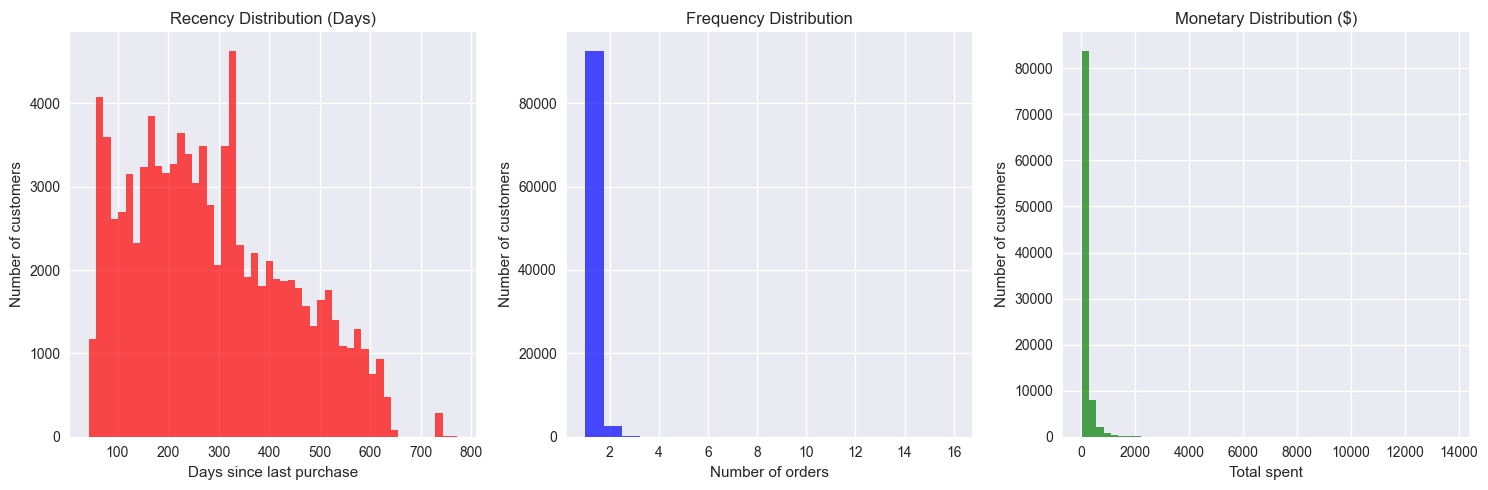

=== RFM SUMMARY STATISTICS ===
Recency - Mean: 286.5 days
Frequency - Mean: 1.0 orders
Monetary - Mean: $166.04
Total customers: 95,420


In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rfm_table['Recency'], bins=50, alpha=0.7, color='red')
plt.title('Recency Distribution (Days)')
plt.xlabel('Days since last purchase')
plt.ylabel('Number of customers')

plt.subplot(1, 3, 2)
plt.hist(rfm_table['Frequency'], bins=20, alpha=0.7, color='blue')
plt.title('Frequency Distribution')
plt.xlabel('Number of orders')
plt.ylabel('Number of customers')

plt.subplot(1, 3, 3)
plt.hist(rfm_table['Monetary'], bins=50, alpha=0.7, color='green')
plt.title('Monetary Distribution ($)')
plt.xlabel('Total spent')
plt.ylabel('Number of customers')

plt.tight_layout()
plt.show()

# RFM Summary stats
print("=== RFM SUMMARY STATISTICS ===")
print(f"Recency - Mean: {rfm_table['Recency'].mean():.1f} days")
print(f"Frequency - Mean: {rfm_table['Frequency'].mean():.1f} orders")
print(f"Monetary - Mean: ${rfm_table['Monetary'].mean():.2f}")
print(f"Total customers: {len(rfm_table):,}")

15: Save Processed Data

In [16]:
# Save customer summary
customer_summary.to_csv('D:\\project\\DataMining\\ecommerce-customer-analytics\\data\\processed\\customer_master.csv', index=False)

# Save RFM data
rfm_table.to_csv('D:\\project\\DataMining\\ecommerce-customer-analytics\\data\\processed\\rfm_data.csv', index=False)

# Save category analysis
category_sales.to_csv('D:\\project\\DataMining\\ecommerce-customer-analytics\\data\\processed\\category_analysis.csv', index=False)

print("✅ All processed data saved successfully!")
print("Files created:")
print("- data/processed/customer_master.csv")
print("- data/processed/rfm_data.csv") 
print("- data/processed/category_analysis.csv")

✅ All processed data saved successfully!
Files created:
- data/processed/customer_master.csv
- data/processed/rfm_data.csv
- data/processed/category_analysis.csv
